# Gaussian Fidelity Landscapes

Mingkang got a weird looking landscape for a gaussian pulse so I am now diagonising the same thing.

In [2]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
import qutip

import system.experimental_september as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as pulse_gen_tukey
importlib.reload(pulse_gen_tukey)
import pulse.gaussian as pulse_gen_gaussian
importlib.reload(pulse_gen_gaussian)
import utils.expectation_values as expect
importlib.reload(expect)

pass

In [3]:
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm
_amp = 1 * 2 * np.pi
_off = 0
_dur = 35

# Compare Pulses

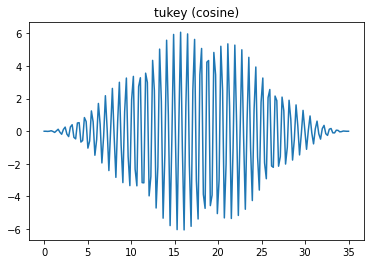

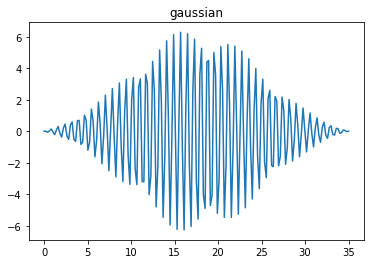

0.09182976892402393

In [4]:
tlist = np.linspace(0, _dur, int(_dur*5))
pulse_gen_tukey.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - 0.3, ramp_coef=1, tlist=tlist)
pulse_gen_gaussian.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - 0.3, sharpness=4.5, tlist=tlist)
plt.plot(tlist, pulse_gen_tukey.get_pulse(tlist))
plt.title("tukey (cosine)")
plt.show()
plt.title("gaussian")
plt.plot(tlist, pulse_gen_gaussian.get_pulse(tlist))
plt.show()

np.mean(np.abs(np.array(pulse_gen_tukey.get_pulse(tlist)) - np.array(pulse_gen_gaussian.get_pulse(tlist))))

# Find centering offset

In [5]:
def vary_offset_tukey(off):
    tlist = np.linspace(0, _dur, int(_dur*5))
    pulse_gen_tukey.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=1, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen_tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": _dur,
        "amplitude": _amp
    }

offs_to_test = np.linspace(-2, 2, 111)
offset_varying_results = parfor(vary_offset_tukey, offs_to_test)

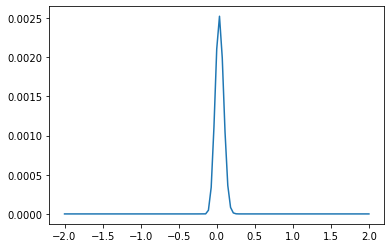

{'fidelity': 0.0025210424513588256,
 'offset': 0.036363636363636154,
 'frequency': 8.28083536240715,
 'duration': 35,
 'amplitude': 6.283185307179586}

In [6]:
_fids_off_sweep = []
_offs_off_sweep = []
for result in offset_varying_results:
    _fids_off_sweep.append(result["fidelity"])
    _offs_off_sweep.append(result["offset"])
plt.plot(_offs_off_sweep, _fids_off_sweep)
plt.show()
offset_varying_results[np.argmax(_fids_off_sweep)]

In [7]:
offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]

0.036363636363636154

## Use Gradient Descent to find better offset

In [8]:
import scipy
offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
duration = offset_varying_results[np.argmax(_fids_off_sweep)]["duration"]
amplitude = offset_varying_results[np.argmax(_fids_off_sweep)]["amplitude"]
parameters = [ offset, duration]
constants = [ amplitude ]

def cost_tukey(parameters, constants):
    # parameters = [offset, duration]
    offset = parameters[0]
    duration = parameters[1]
    # constants = [amplitude]
    amplitude = constants[0]
    tlist = np.linspace(0, duration, int(duration*5))
    pulse_gen_tukey.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=1, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen_tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    return (1-fidelity)

tukey_optimResult = scipy.optimize.minimize(cost_tukey, parameters, constants, method="Nelder-Mead", options={"disp":True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 81
         Function evaluations: 165


In [9]:
tukey_optimResult

 final_simplex: (array([[3.96871750e-02, 1.90633572e+03],
       [3.96871751e-02, 1.90633568e+03],
       [3.96871751e-02, 1.90633565e+03]]), array([4.82781367e-08, 4.85858869e-08, 4.92483415e-08]))
           fun: 4.8278136710599995e-08
       message: 'Optimization terminated successfully.'
          nfev: 165
           nit: 81
        status: 0
       success: True
             x: array([3.96871750e-02, 1.90633572e+03])

# Generate Fidelity Landscapes

## Tukey (Cosine)

In [10]:
def tukey(dur):
    global _amp, _off
    ramp_coef = 1
    tlist = np.linspace(0, dur, int(dur*1))
    pulse_gen_tukey.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, ramp_coef=ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen_tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": _off,
        "frequency":  system.first_energy_spacing/3 - _off,
        "duration": dur,
        "amplitude": _amp,
        "ramp_coef": ramp_coef
    }

In [11]:
tukey_results = []
iterations = 50
best_offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
for i in tqdm(range(0, iterations)):
    _off = np.linspace(best_offset-0.05, best_offset+0.05, iterations)[i]
    already_did_this_offset = False
    for result in tukey_results:
        if result["offset"] == _off:
            already_did_this_offset = True
            break
    if already_did_this_offset:
        continue

    tukey_results += parallel_map(tukey, np.linspace(1, 2000, iterations)) # durations here

  0%|          | 0/50 [00:00<?, ?it/s]../pulse/tukey.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return _amp * 0.5 * (1 + np.cos(np.pi * (-1 + 2.0*t/_ramp_coef/(_t_max)))) * np.cos(t*_wd)
  2%|▏         | 1/50 [02:12<1:48:26, 132.79s/it]../pulse/tukey.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return _amp * 0.5 * (1 + np.cos(np.pi * (-1 + 2.0*t/_ramp_coef/(_t_max)))) * np.cos(t*_wd)
  4%|▍         | 2/50 [04:33<1:50:05, 137.61s/it]../pulse/tukey.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return _amp * 0.5 * (1 + np.cos(np.pi * (-1 + 2.0*t/_ramp_coef/(_t_max)))) * np.cos(t*_wd)
  6%|▌         | 3/50 [06:45<1:45:47, 135.06s/it]../pulse/tukey.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return _amp * 0.5 * (1 + np.cos(np.pi * (-1 + 2.0*t/_ramp_coef/(_t_max)))) * np.cos(t*_wd)
  8%|▊         | 4/50 [09:04<1:44:45, 136.65s/it]../pulse/tukey.py:27: RuntimeWarning: invalid value encountered in

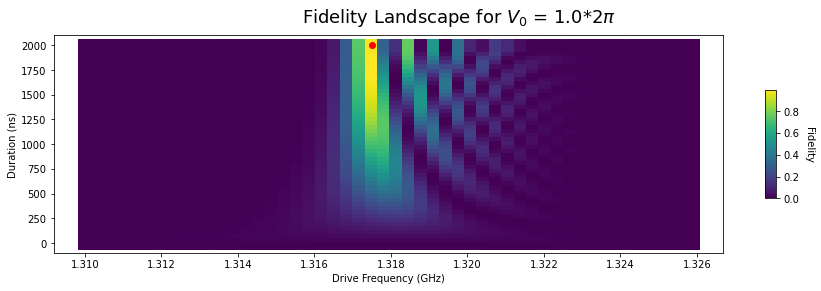

In [57]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
freqs = []
all_results_to_graph = copy.deepcopy(tukey_results)
for result in all_results_to_graph:
    amps.append(result["amplitude"])
    offs.append(result["offset"])
    durs.append(result["duration"])
    fids.append(result["fidelity"])
    freqs.append(result["frequency"] / (2*np.pi))

fig, axs = plt.subplots(figsize=(15, 4))
fig.suptitle("Fidelity Landscape for $V_0$ = %.1f$ * 2\pi$" % (amps[-1]/(2*np.pi)), fontsize=18)
axs.set_xlabel("Drive Frequency (GHz)")
axs.set_ylabel("Duration (ns)")
surf = axs.scatter(freqs, durs, c=fids, cmap="viridis", marker="s", s=150)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_ylabel("Fidelity", rotation=270)
cbar.ax.get_yaxis().labelpad = 15
# axs.pcolormesh(offs, durs, fids)

# pick out a few points around the peak and manually plot them

point_freq = 1.3175
point_dur = np.random.choice(durs)
point_amp = np.random.choice(amps)
axs.scatter(point_freq, point_dur, c='r')
point_freq *= 2*np.pi

# Specific Traces

8.278096642209103 2000.0


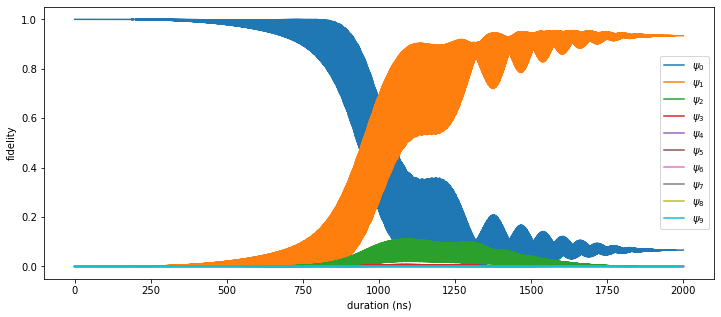

In [58]:
import utils.graph as g

# pick out a few points around the peak and manually plot them
tlist = np.linspace(0, point_dur, int(point_dur*10))
pulse_gen_tukey.setup(point_amp, point_freq, 1, tlist)
solution = solver.time_evolve(system.H0, system.H1, pulse_gen_tukey.pulse_func, tlist, system.starting_state)
g.graph_solution(solution, system)
print(point_freq, point_dur)

8.268671864248336 1500


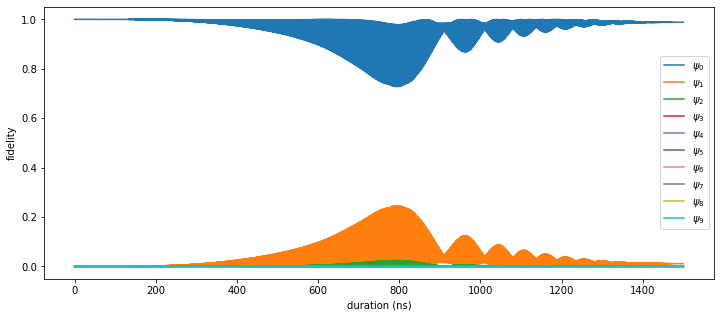

In [59]:

point_dur = 1500
point_freq = 1.316 * 2 * np.pi # 1.3175 is decent on point

# pick out a few points around the peak and manually plot them
tlist = np.linspace(0, point_dur, int(point_dur*10))
pulse_gen_tukey.setup(point_amp, point_freq, 1, tlist)
solution = solver.time_evolve(system.H0, system.H1, pulse_gen_tukey.pulse_func, tlist, system.starting_state)
g.graph_solution(solution, system)
print(point_freq, point_dur)

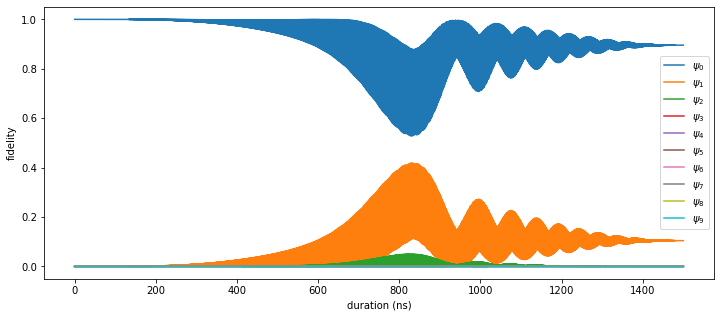

In [60]:

point_dur = 1500
point_freq = 1.3165 * 2 * np.pi # 1.3175 is decent on point

# pick out a few points around the peak and manually plot them
tlist = np.linspace(0, point_dur, int(point_dur*10))
pulse_gen_tukey.setup(point_amp, point_freq, 1, tlist)
solution = solver.time_evolve(system.H0, system.H1, pulse_gen_tukey.pulse_func, tlist, system.starting_state)
g.graph_solution(solution, system)

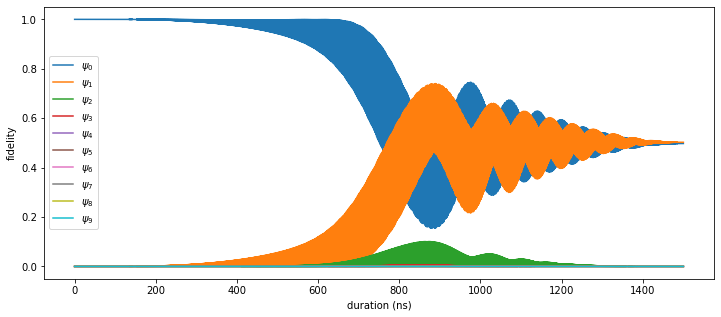

In [61]:

point_dur = 1500
point_freq = 1.317 * 2 * np.pi # 1.3175 is decent on point

# pick out a few points around the peak and manually plot them
tlist = np.linspace(0, point_dur, int(point_dur*10))
pulse_gen_tukey.setup(point_amp, point_freq, 1, tlist)
solution = solver.time_evolve(system.H0, system.H1, pulse_gen_tukey.pulse_func, tlist, system.starting_state)
g.graph_solution(solution, system)

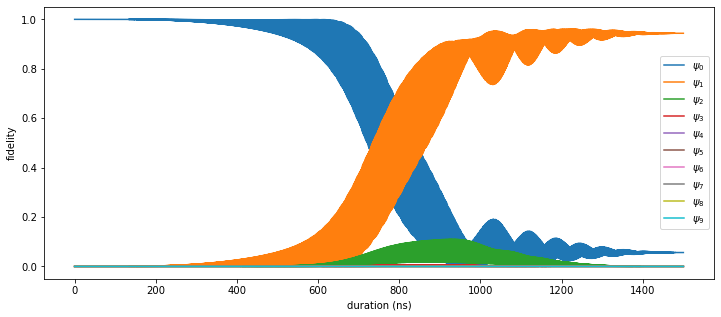

In [62]:
point_dur = 1500
point_freq = 1.3175 * 2 * np.pi # 1.3175 is decent on point

# pick out a few points around the peak and manually plot them
tlist = np.linspace(0, point_dur, int(point_dur*10))
pulse_gen_tukey.setup(point_amp, point_freq, 1, tlist)
solution = solver.time_evolve(system.H0, system.H1, pulse_gen_tukey.pulse_func, tlist, system.starting_state)
g.graph_solution(solution, system)

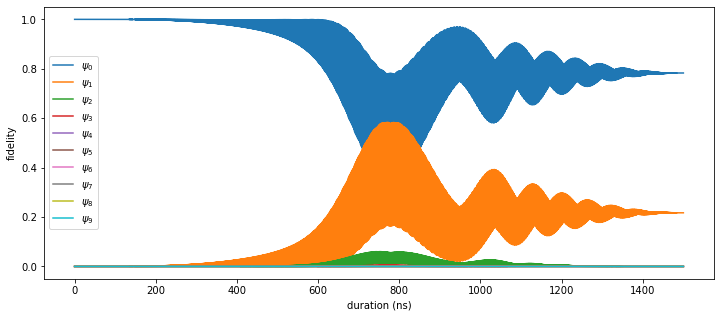

In [63]:
point_dur = 1500
point_freq = 1.318 * 2 * np.pi # 1.3175 is decent on point

# pick out a few points around the peak and manually plot them
tlist = np.linspace(0, point_dur, int(point_dur*10))
pulse_gen_tukey.setup(point_amp, point_freq, 1, tlist)
solution = solver.time_evolve(system.H0, system.H1, pulse_gen_tukey.pulse_func, tlist, system.starting_state)
g.graph_solution(solution, system)

In [64]:
point_dur = 1500
point_freq = 1.3185 * 2 * np.pi # 1.3175 is decent on point

# pick out a few points around the peak and manually plot them
tlist = np.linspace(0, point_dur, int(point_dur*10))
pulse_gen_tukey.setup(point_amp, point_freq, 1, tlist)
solution = solver.time_evolve(system.H0, system.H1, pulse_gen_tukey.pulse_func, tlist, system.starting_state)
g.graph_solution(solution, system)

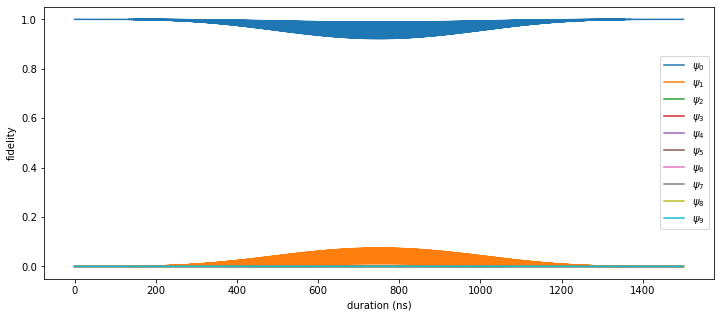

In [43]:
point_dur = 1500
point_freq = 1.4 * 2 * np.pi # 1.3175 is decent on point

# pick out a few points around the peak and manually plot them
tlist = np.linspace(0, point_dur, int(point_dur*10))
pulse_gen_tukey.setup(point_amp, point_freq, 1, tlist)
solution = solver.time_evolve(system.H0, system.H1, pulse_gen_tukey.pulse_func, tlist, system.starting_state)
g.graph_solution(solution, system)

# More Landscapes!

In [25]:
# _results = []

In [31]:
def generate_fidelity_landscape(amplitude, center_offset, duration_bound=250, offset_bounds=0.05, iterations=10):
    global _results, _amp, _off
    offset_iterations = iterations*2
    duration_iterations = iterations
    offs = np.linspace(center_offset-offset_bounds, center_offset+offset_bounds, offset_iterations)
    for i in tqdm(range(0, offset_iterations)):
        off = offs[i]
        already_did_this_offset = False
        durs = np.linspace(4, duration_bound, duration_iterations)
        highest_dur_already_done = 0
        for result in _results:
            if result["amplitude"] == amplitude and result["offset"] == off:
                if result["duration"] > highest_dur_already_done:
                    highest_dur_already_done = result["duration"]
                already_did_this_offset = True
        if already_did_this_offset:
            if highest_dur_already_done >= duration_bound:
                break
            else:
                durs = np.linspace(highest_dur_already_done, duration_bound, duration_iterations)

        # set params for run_once
        _amp = amplitude
        _off = off
        _results += parallel_map(tukey, durs)

In [33]:
generate_fidelity_landscape(1.0*2*np.pi, best_offset)

100%|██████████| 35/35 [07:48<00:00, 13.39s/it]


In [45]:
generate_fidelity_landscape(1.3*2*np.pi, best_offset+0.02)

100%|██████████| 35/35 [04:06<00:00,  7.05s/it]


In [47]:
generate_fidelity_landscape(1.4*2*np.pi, best_offset+0.03)

100%|██████████| 35/35 [04:32<00:00,  7.79s/it]


{8.168140899333462, 6.283185307179586, 7.5398223686155035}


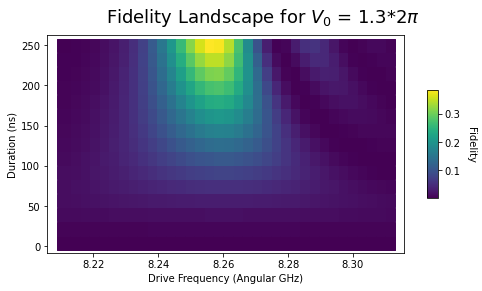

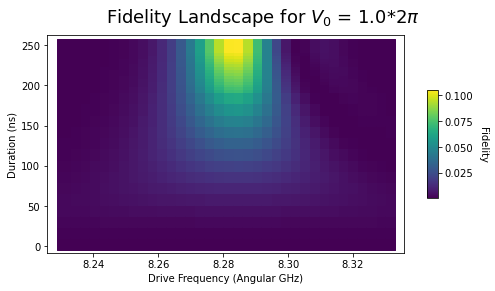

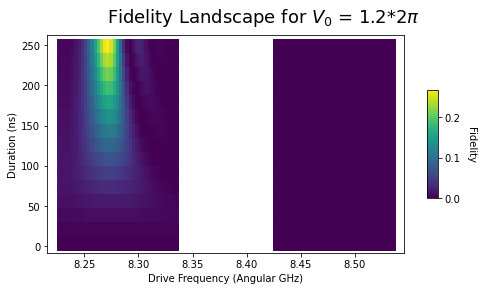

In [46]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
freqs = []
all_results_to_graph = copy.deepcopy(_results)
for result in all_results_to_graph:
    amps.append(result["amplitude"])
meta_amps = set(amps)
print(meta_amps)

for amp in meta_amps:
    offs = []
    durs = []
    fids = []
    freqs = []
    for result in all_results_to_graph:
        # print(result["amplitude"])
        # print(amp)
        # input()
        if result["amplitude"] == amp:
            offs.append(result["offset"])
            durs.append(result["duration"])
            fids.append(result["fidelity"])
            freqs.append(result["frequency"])
    fig, axs = plt.subplots(figsize=(8, 4))
    fig.suptitle("Fidelity Landscape for $V_0$ = %.1f$ * 2\pi$" % (amp/(2*np.pi)), fontsize=18)
    axs.set_xlabel("Drive Frequency (Angular GHz)")
    axs.set_ylabel("Duration (ns)")
    surf = axs.scatter(freqs, durs, c=fids, cmap="viridis", marker="s", s=180)
    cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
    cbar.ax.set_ylabel("Fidelity", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    plt.plot()